## Bakta annotations
Analyse the bakta annotations of MAGs

In [1]:
# imports
import pandas as pd 
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import numpy as np

In [86]:
# read in bakta annotations for the good MAGs 
S1C6_bakta = pd.read_csv('../data/bakta_annotations/S1C6.tsv', sep = '\t', skiprows=5)
S1C5_bakta = pd.read_csv('../data/bakta_annotations/S1C5.tsv', sep = '\t', skiprows=5)
S1C58_bakta = pd.read_csv('../data/bakta_annotations/S1C58.tsv', sep = '\t', skiprows=5)
S1C56_bakta = pd.read_csv('../data/bakta_annotations/S1C56.tsv', sep = '\t', skiprows=5)
S1C53_bakta = pd.read_csv('../data/bakta_annotations/S1C53.tsv', sep = '\t', skiprows=5)
S1C52_bakta = pd.read_csv('../data/bakta_annotations/S1C52.tsv', sep = '\t', skiprows=5)
S1C4_bakta = pd.read_csv('../data/bakta_annotations/S1C4.tsv', sep = '\t', skiprows=5)
S1C3_bakta = pd.read_csv('../data/bakta_annotations/S1C3.tsv', sep = '\t', skiprows=5)
S1C2_bakta = pd.read_csv('../data/bakta_annotations/S1C2.tsv', sep = '\t', skiprows=5)
S1C1_bakta = pd.read_csv('../data/bakta_annotations/S1C1.tsv', sep = '\t', skiprows=5)

In [87]:
# Define categorization function
def categorize_motility(row):
    gene = str(row.get('Gene', '')).lower() if pd.notna(row.get('Gene')) else ''
    product = str(row.get('Product', '')).lower() if pd.notna(row.get('Product')) else ''
    
    # Explicit exclusions for common false positives
    exclude_terms = [
        'chelatase', 'chemical', 'chelator',  # False 'che' matches
        'promoter', 'remote', 'demote',       # False 'mot' matches
        'pilot', 'compilation'                # False 'pil' matches
    ]
    if any(term in product for term in exclude_terms):
        return None
    
    # Gene-based classification (most reliable)
    if gene:
        # Flagellar genes
        if gene in ['mota', 'motb'] or gene.startswith(('flg', 'flh', 'fli', 'fla')):
            return 'Flagellar'
        # Chemotaxis genes
        elif gene.startswith(('che', 'mcp', 'tar', 'tsr', 'trg', 'tap')):
            return 'Chemotaxis'
        # Pilus genes
        elif gene.startswith('pil'):
            return 'Pilus/Twitching'
    
    # Product-based classification - use complete, unambiguous terms
    flagellar_terms = ['flagell', 'basal body', 'hook protein', 'filament protein']
    chemotaxis_terms = ['chemotaxis', 'chemoreceptor', 'methyl-accepting chemotaxis']
    pilus_terms = ['type iv pil', 'type 4 pil', 'twitching motility', 'fimbri']
    
    if any(term in product for term in flagellar_terms):
        return 'Flagellar'
    elif any(term in product for term in chemotaxis_terms):
        return 'Chemotaxis'
    elif any(term in product for term in pilus_terms):
        return 'Pilus/Twitching'
    
    return None

# Define MAG names and file paths
base_path = '/home/grig0076/scratch/TubePaper_2023/Jim_Tube_fastq/vamb_cross_assembly/bakta'
mag_names = ['S1C6', 'S1C5', 'S1C58', 'S1C56', 'S1C53', 'S1C52', 'S1C4', 'S1C3', 'S1C2', 'S1C1']

# Store results for each MAG
all_motility_genes = []
summary_results = []

print("=" * 80)
print("PROCESSING ALL MAGs")
print("=" * 80)

# Process each MAG
for mag_name in mag_names:
    print(f"\nProcessing {mag_name}...")
    
    # Read bakta file
    file_path = f'{base_path}/{mag_name}/{mag_name}.tsv'
    bakta_df = pd.read_csv(file_path, sep='\t', skiprows=5)
    
    # Add MAG identifier column
    bakta_df['MAG_ID'] = mag_name
    
    # Apply categorization
    bakta_df['Motility Category'] = bakta_df.apply(categorize_motility, axis=1)
    
    # Filter to motility genes
    motility_genes = bakta_df[bakta_df['Motility Category'].notna()].copy()
    
    # Store for combined table
    all_motility_genes.append(motility_genes)
    
    # Calculate summary statistics for this MAG
    if len(motility_genes) > 0:
        category_counts = motility_genes['Motility Category'].value_counts()
        summary_row = {
            'MAG_ID': mag_name,
            'Total_Motility_Genes': len(motility_genes),
            'Flagellar': category_counts.get('Flagellar', 0),
            'Chemotaxis': category_counts.get('Chemotaxis', 0),
            'Pilus/Twitching': category_counts.get('Pilus/Twitching', 0)
        }
        summary_results.append(summary_row)
        print(f"  ✓ Found {len(motility_genes)} motility genes")
        print(f"    Flagellar: {summary_row['Flagellar']}, "
              f"Chemotaxis: {summary_row['Chemotaxis']}, "
              f"Pilus/Twitching: {summary_row['Pilus/Twitching']}")
    else:
        summary_row = {
            'MAG_ID': mag_name,
            'Total_Motility_Genes': 0,
            'Flagellar': 0,
            'Chemotaxis': 0,
            'Pilus/Twitching': 0
        }
        summary_results.append(summary_row)
        print(f"  ⚠ No motility genes found")

# Combine all motility genes into one big table
print("\n" + "=" * 80)
print("CREATING COMBINED TABLE")
print("=" * 80)

combined_motility_genes = pd.concat(all_motility_genes, ignore_index=True)
print(f"\n✓ Combined table created with {len(combined_motility_genes)} total motility genes")

# Create summary dataframe
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.set_index('MAG_ID')

print("\n" + "=" * 80)
print("SUMMARY BY MAG")
print("=" * 80)
print(summary_df)

# Quality checks across all MAGs
print("\n" + "=" * 80)
print("QUALITY CHECKS (ALL MAGs)")
print("=" * 80)

# Check for potential false positives
suspicious = combined_motility_genes[
    combined_motility_genes['Product'].str.contains('promoter|chelatase|chemical', case=False, na=False)
]
if len(suspicious) > 0:
    print(f"\n⚠ Found {len(suspicious)} potential false positives:")
    print(suspicious[['MAG_ID', 'Gene', 'Product', 'Motility_Category']].to_string(index=False))
else:
    print("\n✓ No obvious false positives detected")

# Overall category distribution
print("\n" + "=" * 80)
print("OVERALL CATEGORY DISTRIBUTION")
print("=" * 80)
overall_counts = combined_motility_genes['Motility Category'].value_counts()
print(overall_counts)

# Show some examples from each category
print("\n" + "=" * 80)
print("EXAMPLE GENES BY CATEGORY (FROM ALL MAGs)")
print("=" * 80)

for category in ['Flagellar', 'Chemotaxis', 'Pilus/Twitching']:
    category_genes = combined_motility_genes[combined_motility_genes['Motility Category'] == category]
    if len(category_genes) > 0:
        print(f"\n{category} genes (showing 5 examples):")
        print(category_genes[['MAG_ID', 'Gene', 'Product']].head(5).to_string(index=False))
    else:
        print(f"\n{category} genes: None found")

# Save results
print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)


print("\n" + "=" * 80)
print("PROCESSING COMPLETE")
print("=" * 80)
print(f"\nTotal MAGs processed: {len(mag_names)}")
print(f"Total motility genes found: {len(combined_motility_genes)}")

PROCESSING ALL MAGs

Processing S1C6...
  ✓ Found 8 motility genes
    Flagellar: 0, Chemotaxis: 1, Pilus/Twitching: 7

Processing S1C5...
  ✓ Found 34 motility genes
    Flagellar: 23, Chemotaxis: 10, Pilus/Twitching: 1

Processing S1C58...
  ✓ Found 82 motility genes
    Flagellar: 36, Chemotaxis: 11, Pilus/Twitching: 35

Processing S1C56...
  ✓ Found 121 motility genes
    Flagellar: 39, Chemotaxis: 26, Pilus/Twitching: 56

Processing S1C53...
  ✓ Found 69 motility genes
    Flagellar: 40, Chemotaxis: 19, Pilus/Twitching: 10

Processing S1C52...
  ✓ Found 80 motility genes
    Flagellar: 38, Chemotaxis: 27, Pilus/Twitching: 15

Processing S1C4...
  ✓ Found 119 motility genes
    Flagellar: 57, Chemotaxis: 24, Pilus/Twitching: 38

Processing S1C3...
  ✓ Found 9 motility genes
    Flagellar: 0, Chemotaxis: 1, Pilus/Twitching: 8

Processing S1C2...
  ✓ Found 38 motility genes
    Flagellar: 23, Chemotaxis: 13, Pilus/Twitching: 2

Processing S1C1...
  ✓ Found 92 motility genes
    Flage

In [85]:
# create a table of the motility genes that can be provided in the supplementary information 
all_motility_genes_df = pd.concat(all_motility_genes, ignore_index=True)
all_motility_genes_df.to_csv('MAGs_motility_genes.csv')

## Compare the annotations of motility genes encoded by S1C53 and S1C52

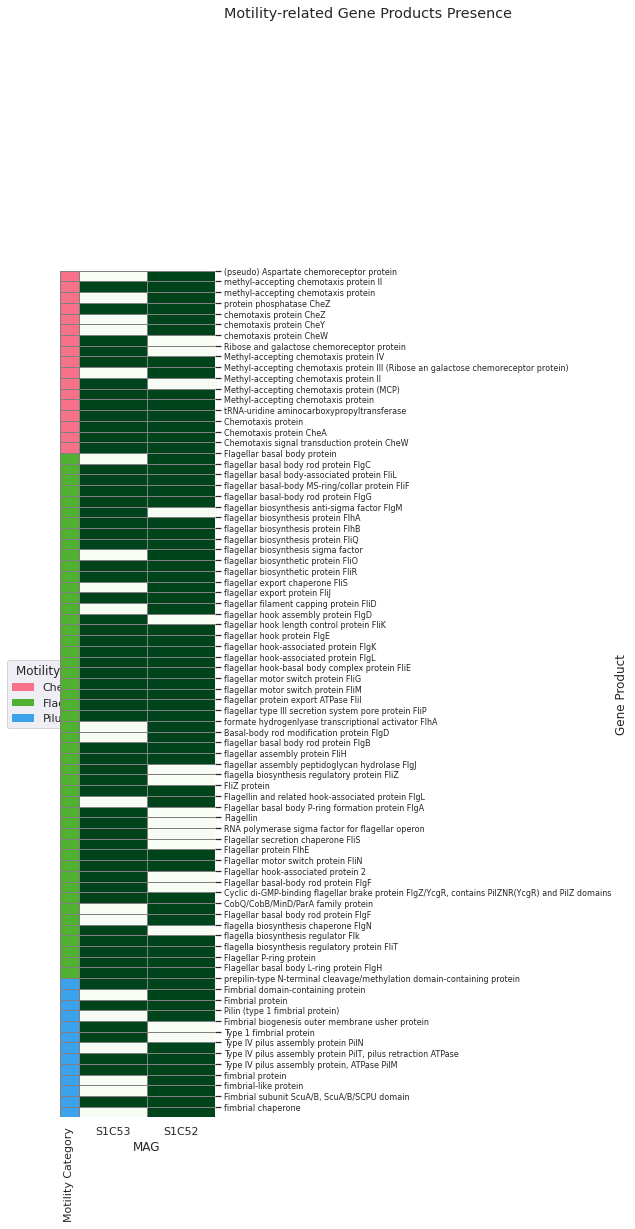

In [76]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Extract product lists ===
motility_products_S1C53 = list(set(all_motility_genes[mag_names.index('S1C53')]['Product']))
motility_products_S1C52 = list(set(all_motility_genes[mag_names.index('S1C52')]['Product']))

# === Combine all unique products ===
all_products = sorted(set(motility_products_S1C53 + motility_products_S1C52))

# === Build presence/absence dataframe ===
df = pd.DataFrame({
    'S1C53': [1 if p in motility_products_S1C53 else 0 for p in all_products],
    'S1C52': [1 if p in motility_products_S1C52 else 0 for p in all_products]
}, index=all_products)

# === Get categories for each product ===
# Combine category data from all used MAGs
combined_cat_df = pd.concat([
    all_motility_genes[mag_names.index('S1C53')][['Product', 'Motility Category']],
    all_motility_genes[mag_names.index('S1C52')][['Product', 'Motility Category']]
]).drop_duplicates(subset='Product').set_index('Product')

categories = (
    combined_cat_df['Motility Category']
    .reindex(all_products)
    .fillna('Unknown')
)

# === Sort both df and categories by category ===
sort_order = categories.sort_values().index
df = df.loc[sort_order]
categories = categories.loc[sort_order]

# === Assign colors to categories ===
unique_cats = categories.unique()
palette = sns.color_palette("husl", len(unique_cats))
cat_colors = dict(zip(unique_cats, palette))
row_colors = categories.map(cat_colors)

# === Create heatmap (remove colorbar properly) ===
g = sns.clustermap(
    df,
    cmap='Greens',
    row_cluster=False,
    col_cluster=False,
    linewidths=0.5,
    linecolor='grey',
    cbar_pos=None,   # <-- removes colorbar safely
    row_colors=row_colors, 
    colors_ratio=(0.1, 0.04) 
)
g.fig.set_size_inches(10, 18)

# === Add category legend ===
for cat, color in cat_colors.items():
    g.ax_row_dendrogram.bar(0, 0, color=color, label=cat, linewidth=0)
g.ax_row_dendrogram.legend(
    loc='center',
    ncol=1,
    bbox_to_anchor=(1.2, 0.5),
    title='Motility Category'
)

g.ax_heatmap.set_yticks(range(df.shape[0]))
g.ax_heatmap.set_yticklabels(df.index, fontsize=8)

# === Label the plot ===
g.fig.suptitle('Motility-related Gene Products Presence', y=1.02)
g.ax_heatmap.set_xlabel('MAG')
g.ax_heatmap.set_ylabel('Gene Product')
plt.savefig('chemotaxis_Leclercia_mags.png', dpi=300, bbox_inches='tight')
plt.show()


In [78]:
df.sum()

S1C53    59
S1C52    63
dtype: int64

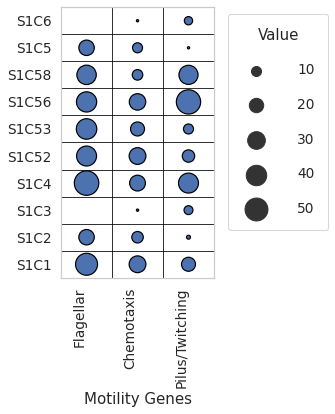

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# increase the fontsize 
sns.set(font_scale=1.25, style='whitegrid')

# Drop the 'Total_Motility_Genes' column
data = summary_df.drop('Total_Motility_Genes', axis=1).copy()

# Preserve the original row order
#data['Row'] = data.index
#data['Row'] = pd.Categorical(data['Row'], categories=summary_df.index, ordered=True)
data['idx'] = [len(data) - i - 1 for i in range(len(data))]

# Melt the DataFrame into long format
data_long = data.melt(id_vars='idx', var_name='Column', value_name='Value')

# Remove rows where Value == 0
data_long = data_long[data_long['Value'] != 0]

plt.figure(figsize=(5, 6))  # Reduced width here
ax = sns.scatterplot(
    data=data_long,
    x='Column',
    y='idx',
    size='Value',
    sizes=(5, 600),
    legend='brief',
    edgecolor='black',
    linewidth=1.2,
    zorder=3,  # Ensure bubbles are drawn on top of grid
)

# Create boxes around each cell
n_rows = len(data_long['idx'].unique())
n_cols = len(data_long['Column'].unique())

# Add rectangular patches to create boxes
for i in range(n_rows + 1):
    ax.axhline(i - 0.5, color='black', linewidth=0.8, zorder=1)
for j in range(n_cols + 1):
    ax.axvline(j - 0.5, color='black', linewidth=0.8, zorder=1)

# Remove the original seaborn grid lines
ax.grid(False)

# Adjust limits to center bubbles in boxes
ax.set_xlim(-0.5, n_cols - 0.5)
ax.set_ylim(-0.5, n_rows - 0.5)

plt.xlabel('Motility Genes')
plt.ylabel('')
plt.xticks(rotation=90, ha='right')
plt.yticks(ticks=data['idx'], labels=['S1C6',
 'S1C5',
 'S1C58',
 'S1C56',
 'S1C53',
 'S1C52',
 'S1C4',
 'S1C3',
 'S1C2',
 'S1C1'])


# Fix the legend spacing
legend = plt.legend(title='Value', bbox_to_anchor=(1.05, 1), loc='upper left', 
                   handletextpad=2, borderpad=1, labelspacing=1.5)
plt.tight_layout()

# Save the figure as PNG
plt.savefig('bubble_plot.png', dpi=300, bbox_inches='tight')
plt.show()